In [14]:
"""
Processing the data
"""
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler


def process_data(train, test, lags):
    """Process data
    Reshape and split train\test data.

    # Arguments
        train: String, name of .csv train file.
        test: String, name of .csv test file.
        lags: integer, time lag.
    # Returns
        X_train: ndarray.
        y_train: ndarray.
        X_test: ndarray.
        y_test: ndarray.
        scaler: StandardScaler.
    """
    attr = 'VFlow'
    df1 = pd.read_csv(train, encoding='utf-8').fillna(0)
    df2 = pd.read_csv(test, encoding='utf-8').fillna(0)

    # scaler = StandardScaler().fit(df1[attr].values)
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(df1[attr].values.reshape(-1, 1))
    flow1 = scaler.transform(df1[attr].values.reshape(-1, 1)).reshape(1, -1)[0]
    flow2 = scaler.transform(df2[attr].values.reshape(-1, 1)).reshape(1, -1)[0]

    train, test = [], []
    for i in range(lags, len(flow1)):
        train.append(flow1[i - lags: i + 1])
    for i in range(lags, len(flow2)):
        test.append(flow2[i - lags: i + 1])

    train = np.array(train)
    test = np.array(test)
    np.random.shuffle(train)

    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_test = test[:, :-1]
    y_test = test[:, -1]

    return X_train, y_train, X_test, y_test, scaler

In [15]:
def train_model(model, X_train, y_train, name, config):
    """train
    train a single model.

    # Arguments
        model: Model, NN model to train.
        X_train: ndarray(number, lags), Input data for train.
        y_train: ndarray(number, ), result data for train.
        name: String, name of model.
        config: Dict, parameter for train.
    """

    model.compile(loss="mse", optimizer="rmsprop", metrics=['mape'])
    model.summary()
    # early = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='auto')
    hist = model.fit(
        X_train, y_train,
        batch_size=config["batch"],
        epochs=config["epochs"],
        validation_split=0.05)

    model.save('model/' + name + '.h5')
    df = pd.DataFrame.from_dict(hist.history)
    df.to_csv('model/' + name + ' loss.csv', encoding='utf-8', index=False)

In [16]:
def do_train(model_name):
    lag = 12
    config = {"batch": 256, "epochs": 500}
    file1 = 'data/train.csv'
    file2 = 'data/test.csv'
    X_train, y_train, _, _, _ = process_data(file1, file2, lag)

    if model_name == 'lstm':
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        m = get_lstm([12, 64, 64, 1])
        train_model(m, X_train, y_train, model_name, config)
    if model_name == 'gru':
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        m = get_gru([12, 64, 64, 1])
        train_model(m, X_train, y_train, model_name, config)
    if model_name == 'sae':
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
        m = get_sae([12, 432, 216, 108, 216, 432, 12, 1])
        train_model(m, X_train, y_train, model_name, config)
    if model_name == 'nt_saes':
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
        m = get_nt_saes([12, 400, 400, 400, 1])
        train_nt_saes(m, X_train, y_train, model_name, config)

In [28]:
"""
Defination of NN model
"""
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM, GRU
from keras.models import Sequential, Model
from keras import Input


def get_lstm(units):
    """LSTM(Long Short-Term Memory)
    Build LSTM Model.

    # Arguments
        units: List(int), number of input, output and hidden units.
    # Returns
        model: Model, nn model.
    """

    model = Sequential()
    model.add(LSTM(units[1], input_shape=(units[0], 1), return_sequences=True))
    model.add(LSTM(units[2]))
    model.add(Dropout(0.2))
    model.add(Dense(units[3], activation='sigmoid'))

    return model


def get_gru(units):
    """GRU(Gated Recurrent Unit)
    Build GRU Model.

    # Arguments
        units: List(int), number of input, output and hidden units.
    # Returns
        model: Model, nn model.
    """

    model = Sequential()
    model.add(GRU(units[1], input_shape=(units[0], 1), return_sequences=True))
    model.add(GRU(units[2]))
    model.add(Dropout(0.2))
    model.add(Dense(units[3], activation='sigmoid'))

    return model


def get_sae(layers):    
    sae = Sequential()
    sae.add(Input([layers[0]]))
    sae.add(Dense(layers[0], activation='relu', name='input_inflate'))
    sae.add(Dense(layers[1], activation='relu', name='encoder_1'))
    sae.add(Dense(layers[2], activation='relu', name='encoder_2'))
    sae.add(Dense(layers[3], activation='relu', name='hidden_bottleneck'))
    sae.add(Dense(layers[4], activation='relu', name='decoder_2'))
    sae.add(Dense(layers[5], activation='relu', name='decoder_1'))
    sae.add(Dense(layers[6], activation='relu', name='output_deflate'))
    sae.add(Dense(layers[7], activation='sigmoid'))

    return sae


def _get_nt_sae(inputs, hidden, output):
    """SAE(Auto-Encoders)
    Build SAE Model.

    # Arguments
        inputs: Integer, number of input units.
        hidden: Integer, number of hidden units.
        output: Integer, number of output units.
    # Returns
        model: Model, nn model.
    """

    model = Sequential()
    model.add(Dense(hidden, input_dim=inputs, name='hidden'))
    model.add(Activation('sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(output, activation='sigmoid'))

    return model


def get_nt_saes(layers):
    """SAEs(Stacked Auto-Encoders)
    Build SAEs Model.

    # Arguments
        layers: List(int), number of input, output and hidden units.
    # Returns
        models: List(Model), List of SAE and SAEs.
    """
    sae1 = _get_nt_sae(layers[0], layers[1], layers[-1])
    sae2 = _get_nt_sae(layers[1], layers[2], layers[-1])
    sae3 = _get_nt_sae(layers[2], layers[3], layers[-1])

    saes = Sequential()
    saes.add(Dense(layers[1], input_dim=layers[0], name='hidden1'))
    saes.add(Activation('sigmoid'))
    saes.add(Dense(layers[2], name='hidden2'))
    saes.add(Activation('sigmoid'))
    saes.add(Dense(layers[3], name='hidden3'))
    saes.add(Activation('sigmoid'))
    saes.add(Dropout(0.2))
    saes.add(Dense(layers[4], activation='sigmoid'))

    models = [sae1, sae2, sae3, saes]

    return models

In [29]:
def train_nt_saes(models, X_train, y_train, name, config):
    """train
    train the SAEs model.

    # Arguments
        models: List, list of SAE model.
        X_train: ndarray(number, lags), Input data for train.
        y_train: ndarray(number, ), result data for train.
        name: String, name of model.
        config: Dict, parameter for train.
    """

    temp = X_train
    # early = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='auto')

    for i in range(len(models) - 1):
        if i > 0:
            p = models[i - 1]
            hidden_layer_model = Model(inputs=p.inputs,
                                       outputs=p.get_layer('hidden').output)
            temp = hidden_layer_model.predict(temp)

        m = models[i]
        m.compile(loss="mse", optimizer="rmsprop", metrics=['mape'])

        m.fit(temp, y_train, batch_size=config["batch"],
              epochs=config["epochs"],
              validation_split=0.05)

        models[i] = m

    saes = models[-1]
    for i in range(len(models) - 1):
        weights = models[i].get_layer('hidden').get_weights()
        saes.get_layer('hidden%d' % (i + 1)).set_weights(weights)

    train_model(saes, X_train, y_train, name, config)

## warning: this stuff will take ages to run and needs GPU time

In [30]:
from keras.models import Model
from keras.callbacks import EarlyStopping

In [24]:
do_train('sae')

I0000 00:00:1727313698.815191  446007 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727313698.843190  446007 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727313698.843262  446007 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727313698.844863  446007 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727313698.844921  446007 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_inflate (Dense)           │ (None, 12)             │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (Dense)               │ (None, 432)            │         5,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_2 (Dense)               │ (None, 216)            │        93,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_bottleneck (Dense)       │ (None, 108)            │        23,436 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Dense)               │ (None, 216)            │        23,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Dense)               │ (None, 432)            │        93,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_deflate (Dense)          │ (None, 12)             │         5,196 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 245,233 (957.94 KB)

 Trainable params: 245,233 (957.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500


I0000 00:00:1727313721.379425  447122 service.cc:146] XLA service 0x7fe19c00b6b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727313721.379462  447122 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-09-26 11:22:01.399097: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-26 11:22:01.528547: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-09-26 11:22:03.306774: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_129', 320 bytes spill stores, 320 bytes spill loads

2024-09-26 11:22:05.368269: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in funct

 1/31 ━━━━━━━━━━━━━━━━━━━━ 5:33 11s/step - loss: 0.1009 - mape: 765.9933

I0000 00:00:1727313731.753320  447122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-09-26 11:22:13.465335: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_129', 632 bytes spill stores, 624 bytes spill loads



31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - loss: 0.0653 - mape: 641204.1875

2024-09-26 11:22:24.180808: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_47', 76 bytes spill stores, 76 bytes spill loads

2024-09-26 11:22:24.517628: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_47', 632 bytes spill stores, 624 bytes spill loads



31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 560ms/step - loss: 0.0645 - mape: 633122.0625 - val_loss: 0.0076 - val_mape: 185566.5156
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104 - mape: 140771.7344 - val_loss: 0.0067 - val_mape: 146877.3906
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0098 - mape: 106975.7500 - val_loss: 0.0049 - val_mape: 159033.1875
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0064 - mape: 92328.1953 - val_loss: 0.0045 - val_mape: 152523.5781
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0063 - mape: 45262.4297 - val_loss: 0.0044 - val_mape: 122952.4688
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053 - mape: 83085.9219 - val_loss: 0.0038 - val_mape: 130141.5469
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055 - mape: 70262.2734 - val_loss: 0.0040 - val_mape: 114635.3828
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047 - mape: 163564.7031 - val_loss: 0.0035 - val

In [31]:
do_train('nt_saes')

Epoch 1/500


/home/jesus/main/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0638 - mape: 420128.9688 - val_loss: 0.0366 - val_mape: 295.2739
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0364 - mape: 470692.9688 - val_loss: 0.0221 - val_mape: 239.6900
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0270 - mape: 333210.4688 - val_loss: 0.0183 - val_mape: 174.2617
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0230 - mape: 217341.5469 - val_loss: 0.0151 - val_mape: 179.0919
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0215 - mape: 205004.0000 - val_loss: 0.0135 - val_mape: 154.0934
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0192 - mape: 281438.1250 - val_loss: 0.0137 - val_mape: 179.0844
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0186 - mape: 246575.5938 - val_loss: 0.0124 - val_mape: 117.5873
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0174 - mape: 265727.0000 - val_loss: 0.0112 - val_mape: 160.6633
Epo

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden1 (Dense)                 │ (None, 400)            │         5,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 400)            │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden3 (Dense)                 │ (None, 400)            │       160,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 326,401 (1.25 MB)

 Trainable params: 326,401 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500


2024-09-26 11:27:10.885767: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_361', 384 bytes spill stores, 380 bytes spill loads

2024-09-26 11:27:11.071803: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_648', 124 bytes spill stores, 124 bytes spill loads



20/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1058 - mape: 738837.1250  

2024-09-26 11:27:13.767167: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_361', 660 bytes spill stores, 660 bytes spill loads



31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.0984 - mape: 640446.3750

2024-09-26 11:27:16.542618: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 88 bytes spill stores, 88 bytes spill loads

2024-09-26 11:27:16.863335: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_30', 660 bytes spill stores, 660 bytes spill loads



31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - loss: 0.0978 - mape: 633928.8750 - val_loss: 0.0574 - val_mape: 214.1659
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0548 - mape: 260306.4375 - val_loss: 0.0204 - val_mape: 146.5515
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0305 - mape: 422190.5938 - val_loss: 0.0170 - val_mape: 234.2867
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0204 - mape: 151972.6406 - val_loss: 0.0100 - val_mape: 60.3968
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0157 - mape: 176331.4062 - val_loss: 0.0048 - val_mape: 86.4380
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0145 - mape: 91550.5859 - val_loss: 0.0077 - val_mape: 50.8825
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0134 - mape: 59242.1602 - val_loss: 0.0063 - val_mape: 92.4755
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0118 - mape: 111717.7188 - val_loss: 0.0039 - val_mape: 60.2903
Epoch 9/5

In [ ]:
do_train('gru')

In [10]:
do_train('lstm')

Epoch 1/500


c:\Users\Ben\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0719 - mape: 625751.5625 - val_loss: 0.0318 - val_mape: 191.2047
Epoch 2/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0291 - mape: 289894.8750 - val_loss: 0.0295 - val_mape: 152.8069
Epoch 3/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0234 - mape: 179886.4219 - val_loss: 0.0239 - val_mape: 156.8578
Epoch 4/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0197 - mape: 176446.3281 - val_loss: 0.0183 - val_mape: 158.1291
Epoch 5/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0149 - mape: 285369.3750 - val_loss: 0.0130 - val_mape: 158.6632
Epoch 6/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0118 - mape: 230626.7656 - val_loss: 0.0101 - val_mape: 146.0703
Epoch 7/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0107 - mape: 192326.5938 - val_loss: 0.0103 - val_mape: 120.9747
Epoch 8/500
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0102 - mape: 319584.9375 - val_loss: 0.0091 - val_mape: 113.0

## end of warning

In [34]:
import math
import warnings
import numpy as np
import pandas as pd
from keras.models import load_model
from tensorflow.keras.utils import plot_model
import sklearn.metrics as metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from keras.src.legacy.saving import legacy_h5_format

In [37]:
def MAPE(y_true, y_pred):
    """Mean Absolute Percentage Error
    Calculate the mape.

    # Arguments
        y_true: List/ndarray, ture data.
        y_pred: List/ndarray, predicted data.
    # Returns
        mape: Double, result data for train.
    """

    y = [x for x in y_true if x > 0]
    y_pred = [y_pred[i] for i in range(len(y_true)) if y_true[i] > 0]

    num = len(y_pred)
    sums = 0

    for i in range(num):
        tmp = abs(y[i] - y_pred[i]) / y[i]
        sums += tmp

    mape = sums * (100 / num)

    return mape


def eva_regress(y_true, y_pred):
    """Evaluation
    evaluate the predicted resul.

    # Arguments
        y_true: List/ndarray, ture data.
        y_pred: List/ndarray, predicted data.
    """

    mape = MAPE(y_true, y_pred)
    vs = metrics.explained_variance_score(y_true, y_pred)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    print('explained_variance_score:%f' % vs)
    print('mape:%f%%' % mape)
    print('mae:%f' % mae)
    print('mse:%f' % mse)
    print('rmse:%f' % math.sqrt(mse))
    print('r2:%f' % r2)

def plot_results(y_true, y_preds, names):
    """Plot
    Plot the true data and predicted data.

    # Arguments
        y_true: List/ndarray, ture data.
        y_pred: List/ndarray, predicted data.
        names: List, Method names.
    """
    d = '2016-3-4 00:00'
    x = pd.date_range(d, periods=96, freq='15min')

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(x, y_true, label='True Data')
    for name, y_pred in zip(names, y_preds):
        ax.plot(x, y_pred, label=name)

    plt.legend()
    plt.grid(True)
    plt.xlabel('Time of Day')
    plt.ylabel('Flow')

    date_format = mpl.dates.DateFormatter("%H:%M")
    ax.xaxis.set_major_formatter(date_format)
    fig.autofmt_xdate()


def main():
    #lstm = load_model('model/lstm.h5')
    gru = legacy_h5_format.load_model_from_hdf5("model/gru.h5", custom_objects={'mse': 'mse'})
    sae = legacy_h5_format.load_model_from_hdf5("model/sae.h5", custom_objects={'mse': 'mse'})
    nt_saes = legacy_h5_format.load_model_from_hdf5("model/nt_saes.h5", custom_objects={'mse': 'mse'})
    lstm = legacy_h5_format.load_model_from_hdf5("model/lstm.h5", custom_objects={'mse': 'mse'})
    models = [lstm, gru, sae, nt_saes]
    names = ['LSTM', 'GRU', 'SAE', 'NT_SAEs']

    lag = 12
    file1 = 'data/train.csv'
    file2 = 'data/test.csv'
    _, _, X_test, y_test, scaler = process_data(file1, file2, lag)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(1, -1)[0]

    y_preds = []
    for name, model in zip(names, models):
        if name == 'SAEs':
            X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))
        else:
            X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        file = 'images/' + name + '.png'
        plot_model(model, to_file=file, show_shapes=True)
        predicted = model.predict(X_test)
        predicted = scaler.inverse_transform(predicted.reshape(-1, 1)).reshape(1, -1)[0]
        y_preds.append(predicted[:96])
        print(name)
        eva_regress(y_test, predicted)

    plot_results(y_test[: 96], y_preds, names)

You must install pydot (`pip install pydot`) for `plot_model` to work.
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
LSTM
explained_variance_score:0.946548
mape:34.687209%
mae:16.689780
mse:614.517216
rmse:24.789458
r2:0.945224
You must install pydot (`pip install pydot`) for `plot_model` to work.
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
GRU
explained_variance_score:0.944069
mape:41.632485%
mae:17.286446
mse:644.423317
rmse:25.385494
r2:0.942558
You must install pydot (`pip install pydot`) for `plot_model` to work.
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step
SAE
explained_variance_score:0.933674
mape:28.745824%
mae:18.046390
mse:747.572371
rmse:27.341770
r2:0.933363
You must install pydot (`pip install pydot`) for `plot_model` to work.
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
NT_SAEs
explained_variance_score:0.940622
mape:39.865008%
mae:17.812832
mse:670.691872
rmse:25.897719
r2:0.940216


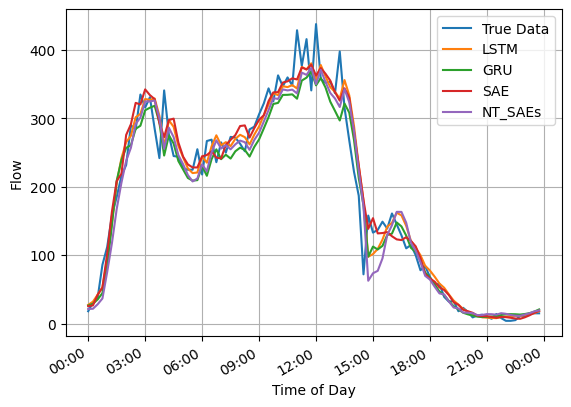

In [38]:
main()